## Load the model

In [ ]:
import os 
# Optionally set Hugging Face cache directory
# os.environ["HF_HOME"] = "<HF_CACHE_DIR>"  # e.g., /data/huggingface_cache

from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, GenerationConfig
from qwen_vl_utils import process_vision_info
import torch
import re

MODEL_PATH = 'JZPeterPan/MedVLM-R1'

model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

processor = AutoProcessor.from_pretrained(MODEL_PATH)

temp_generation_config = GenerationConfig(
    max_new_tokens=1024,
    do_sample=False,  
    temperature=1, 
    num_return_sequences=1,
    pad_token_id=151643,
)


/home/vipuser/miniconda3/envs/r1v-realshit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Load one of the following VQA examples

What can be observed in this image?
A) Chondral abnormality
B) Bone density loss
C) Synovial cyst formation
D) Ligament tear 
Groundtruth Solution: A


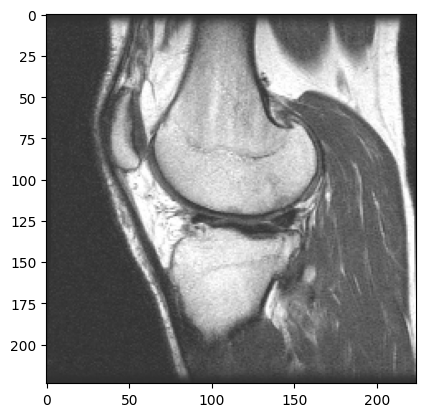

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


question = {"image": ['images/successful_cases/mdb146.png'], "problem": "What content appears in this image?\nA) Cardiac tissue\nB) Breast tissue\nC) Liver tissue\nD) Skin tissue", "solution": "B", "answer": "Breast tissue"}

# question = {"image": ["images/successful_cases/person19_virus_50.jpeg"], "problem": "What content appears in this image?\nA) Lungs\nB) Bladder\nC) Brain\nD) Heart", "solution": "A", "answer": "Lungs"}

# question = {"image":["images/successful_cases/abd-normal023599.png"],"problem":"Is any abnormality evident in this image?\nA) No\nB) Yes.","solution":"A","answer":"No"}

# question = {"image":["images/successful_cases/foot089224.png"],"problem":"Which imaging technique was utilized for acquiring this image?\nA) MRI\nB) Electroencephalogram (EEG)\nC) Ultrasound\nD) Angiography","solution":"A","answer":"MRI"}

# question = {"image":["images/successful_cases/knee031316.png"],"problem":"What can be observed in this image?\nA) Chondral abnormality\nB) Bone density loss\nC) Synovial cyst formation\nD) Ligament tear","solution":"A","answer":"Chondral abnormality"}

# question = {"image":["images/successful_cases/shoulder045906.png"],"problem":"What can be visually detected in this picture?\nA) Bone fracture\nB) Soft tissue fluid\nC) Blood clot\nD) Tendon tear","solution":"B","answer":"Soft tissue fluid"}

# question = {"image":["images/successful_cases/brain003631.png"],"problem":"What attribute can be observed in this image?\nA) Focal flair hyperintensity\nB) Bone fracture\nC) Vascular malformation\nD) Ligament tear","solution":"A","answer":"Focal flair hyperintensity"}

# question = {"image":["images/successful_cases/mrabd005680.png"],"problem":"What can be observed in this image?\nA) Pulmonary embolism\nB) Pancreatic abscess\nC) Intraperitoneal mass\nD) Cardiac tamponade","solution":"C","answer":"Intraperitoneal mass"}

print(question["problem"], '\nGroundtruth Solution:',question["solution"])

img = mpimg.imread(question["image"][0])
plt.imshow(img, cmap='gray')
plt.show()



## Run the inference 

In [16]:
QUESTION_TEMPLATE = """
    {Question} 
    Your task: 
    1. Think through the question step by step, enclose your reasoning process in <think>...</think> tags. 
    2. Then provide the correct single-letter choice (A, B, C, D,...) inside <answer>...</answer> tags.
    3. No extra information or text outside of these tags.
    """

message = [{
    "role": "user",
    "content": [{"type": "image", "image": f"file://{question['image'][0]}"}, {"type": "text","text": QUESTION_TEMPLATE.format(Question=question['problem'])}]
}]

text = processor.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
    
image_inputs, video_inputs = process_vision_info(message)
inputs = processor(
    text=text,
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to("cuda")

generated_ids = model.generate(**inputs, use_cache=True, max_new_tokens=1024, do_sample=False, generation_config=temp_generation_config)

generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)

print(f'model output: \n{output_text[0]}')


model output: 
<think>
    The image is a magnetic resonance imaging (MRI) scan of a knee joint. The scan shows a chondral abnormality, which is a type of cartilage damage. This is evident from the irregular shape and the presence of a defect in the cartilage.
</think>

<answer>A</answer>
